# Predict Heart Disease
Arshak Parsa

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import *
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_curve, 
    auc
)

sns.set_theme(style="whitegrid")

In [3]:
# from ucimlrepo import fetch_ucirepo 
# from pathlib import Path
# import os.path
# import pickle

# home = Path.home()

# # Source - https://stackoverflow.com/a
# # Posted by martineau, modified by community. See post 'Timeline' for change history
# # Retrieved 2025-11-22, License - CC BY-SA 4.0
# # https://stackoverflow.com/questions/4529815/saving-an-object-data-persistence

# def save_object(obj, filename):
#     with open(filename, 'wb') as outp:  # Overwrites any existing file.
#         pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

# file_path = home / 'Desktop/heart_disease.pkl'

# if os.path.isfile(file_path):
#     print("--- Load the dataset ---")
#     with (open(file_path, "rb")) as openfile:
#         heart_disease = pickle.load(openfile)
# else: 
#     print("--- Download the dataset ---")
#     # fetch dataset 
#     heart_disease = fetch_ucirepo(id=45) 
#     # sample usage
#     save_object(heart_disease,file_path)

In [4]:
# df = pd.concat([heart_disease.data.features ,heart_disease.data.targets ], axis=1)
# df['num'] = df['num'].astype('category')
# # metadata 
# pprint(heart_disease.metadata) 

In [5]:
# # variable information 
# print(heart_disease.variables) 

In [6]:
df = pd.read_csv('heart.csv')
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

No missing data in kaggle dataset.

In [7]:
nominal_var = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'thal']
ordinal_var = ['slope']
numerical_var = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca'] 
len(nominal_var),len(ordinal_var),len(numerical_var)

(6, 1, 6)

The description for most of these features are just too complicated for me! I don't understand medical jargon and it's hard to decide which one is ordinal!

I think slope might be an ordinal variable because the possible variables are these:

Value 1: upsloping

Value 2: flat

Value 3: downsloping

# EDA

In [8]:
print("--- Phase 1: Data Ingestion & First Look ---")

print(f"Dataset shape (rows, columns): {df.shape}\n")

print("First 5 rows (head):")
print(df.head())
print("\nLast 5 rows (tail):")
print(df.tail())

print("\nData types and non-null counts (info):")
df.info()

--- Phase 1: Data Ingestion & First Look ---
Dataset shape (rows, columns): (1025, 14)

First 5 rows (head):
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  

Last 5 rows (tail):
      age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
1020   59    1   1       140   221    0        1      164      1      0.0   
1021   60    1   0       125   258    0        0      141      1      2.8   
1022   47    1   0  

In [9]:
df[nominal_var + ordinal_var + ['target']] = df[nominal_var + ordinal_var + ['target']].apply(lambda x: x.astype('category'))

In [10]:
print(f"Total duplicated rows: {df.duplicated().sum()}")
df = df.drop_duplicates()

Total duplicated rows: 723


Oops! Duplicated rows? Sorry you are not allowed here! 

This dataset has been probably preprocessed!

In [11]:
print("\n--- Phase 2: Univariate Analysis ---")

print("\nDescriptive statistics for numerical features:")
print(df[numerical_var].describe())


--- Phase 2: Univariate Analysis ---

Descriptive statistics for numerical features:
             age    trestbps        chol     thalach     oldpeak          ca
count  302.00000  302.000000  302.000000  302.000000  302.000000  302.000000
mean    54.42053  131.602649  246.500000  149.569536    1.043046    0.718543
std      9.04797   17.563394   51.753489   22.903527    1.161452    1.006748
min     29.00000   94.000000  126.000000   71.000000    0.000000    0.000000
25%     48.00000  120.000000  211.000000  133.250000    0.000000    0.000000
50%     55.50000  130.000000  240.500000  152.500000    0.800000    0.000000
75%     61.00000  140.000000  274.750000  166.000000    1.600000    1.000000
max     77.00000  200.000000  564.000000  202.000000    6.200000    4.000000


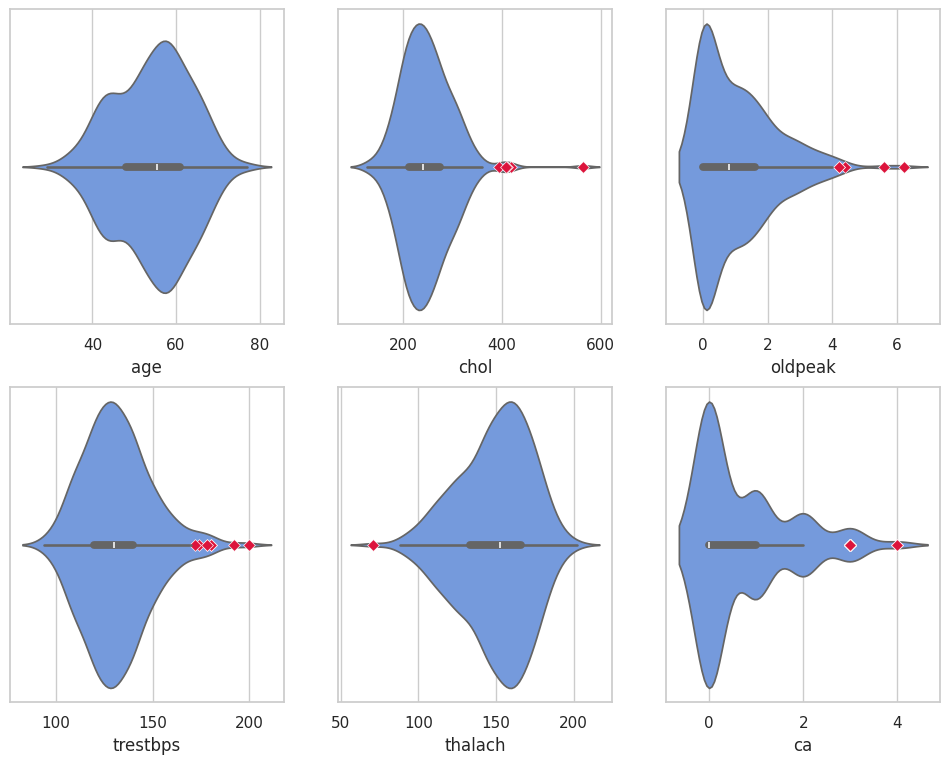

In [12]:
# Source - https://stackoverflow.com/questions/66913456/how-to-mix-the-outliers-from-boxplot-or-not-with-violin-plot
def custom_violinplot(d,ax,xlabel,bw_adjust=1):
    q1, q3 = np.percentile(d, [25, 75])
    whisker_low = q1 - (q3 - q1) * 1.5
    whisker_high = q3 + (q3 - q1) * 1.5
    sns.violinplot(x=d, color='CornflowerBlue', ax=ax, bw_adjust=bw_adjust)
    outliers = d[(d > whisker_high) | (d < whisker_low)]
    if len(outliers):
        sns.scatterplot(x=outliers, y=0, marker='D', color='crimson', ax=ax)
    plt.xlabel(xlabel)
    
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (12,9))
custom_violinplot(df['age'] ,axs[0][0], 'age')
custom_violinplot(df['trestbps'] ,axs[1][0], 'trestbps')
custom_violinplot(df['chol'] ,axs[0][1], 'chol')
custom_violinplot(df['thalach'] ,axs[1][1], 'thalach')
custom_violinplot(df['oldpeak'] ,axs[0][2], 'oldpeak')
custom_violinplot(df['ca'] ,axs[1][2], 'ca')


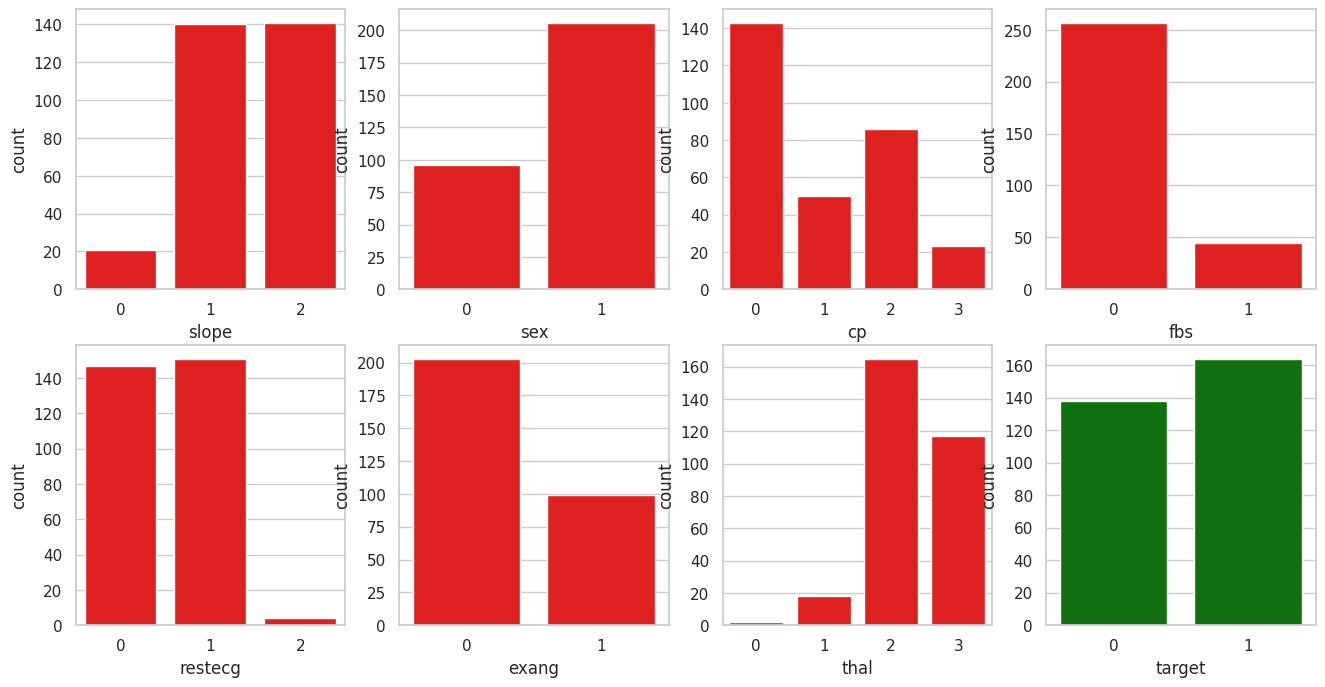

In [13]:
cats = np.reshape(ordinal_var+nominal_var+['target'],(2,4))
alpha = 4
fig, axs = plt.subplots(ncols = 4, nrows = 2, figsize=(4*alpha, 2*alpha))
for i in range(cats.shape[0]):
    for j in range(cats.shape[1]):
        cl = 'green'
        pval = stats.chisquare(df[cats[i][j]].value_counts().values).pvalue
        if pval < 0.05:
            cl = 'red'
        sns.countplot(x=df[cats[i][j]], ax = axs[i][j], color = cl)


None of the features are balanced!

The target is balanced, which is good!


--- Phase 3: Bivariate & Multivariate Analysis ---


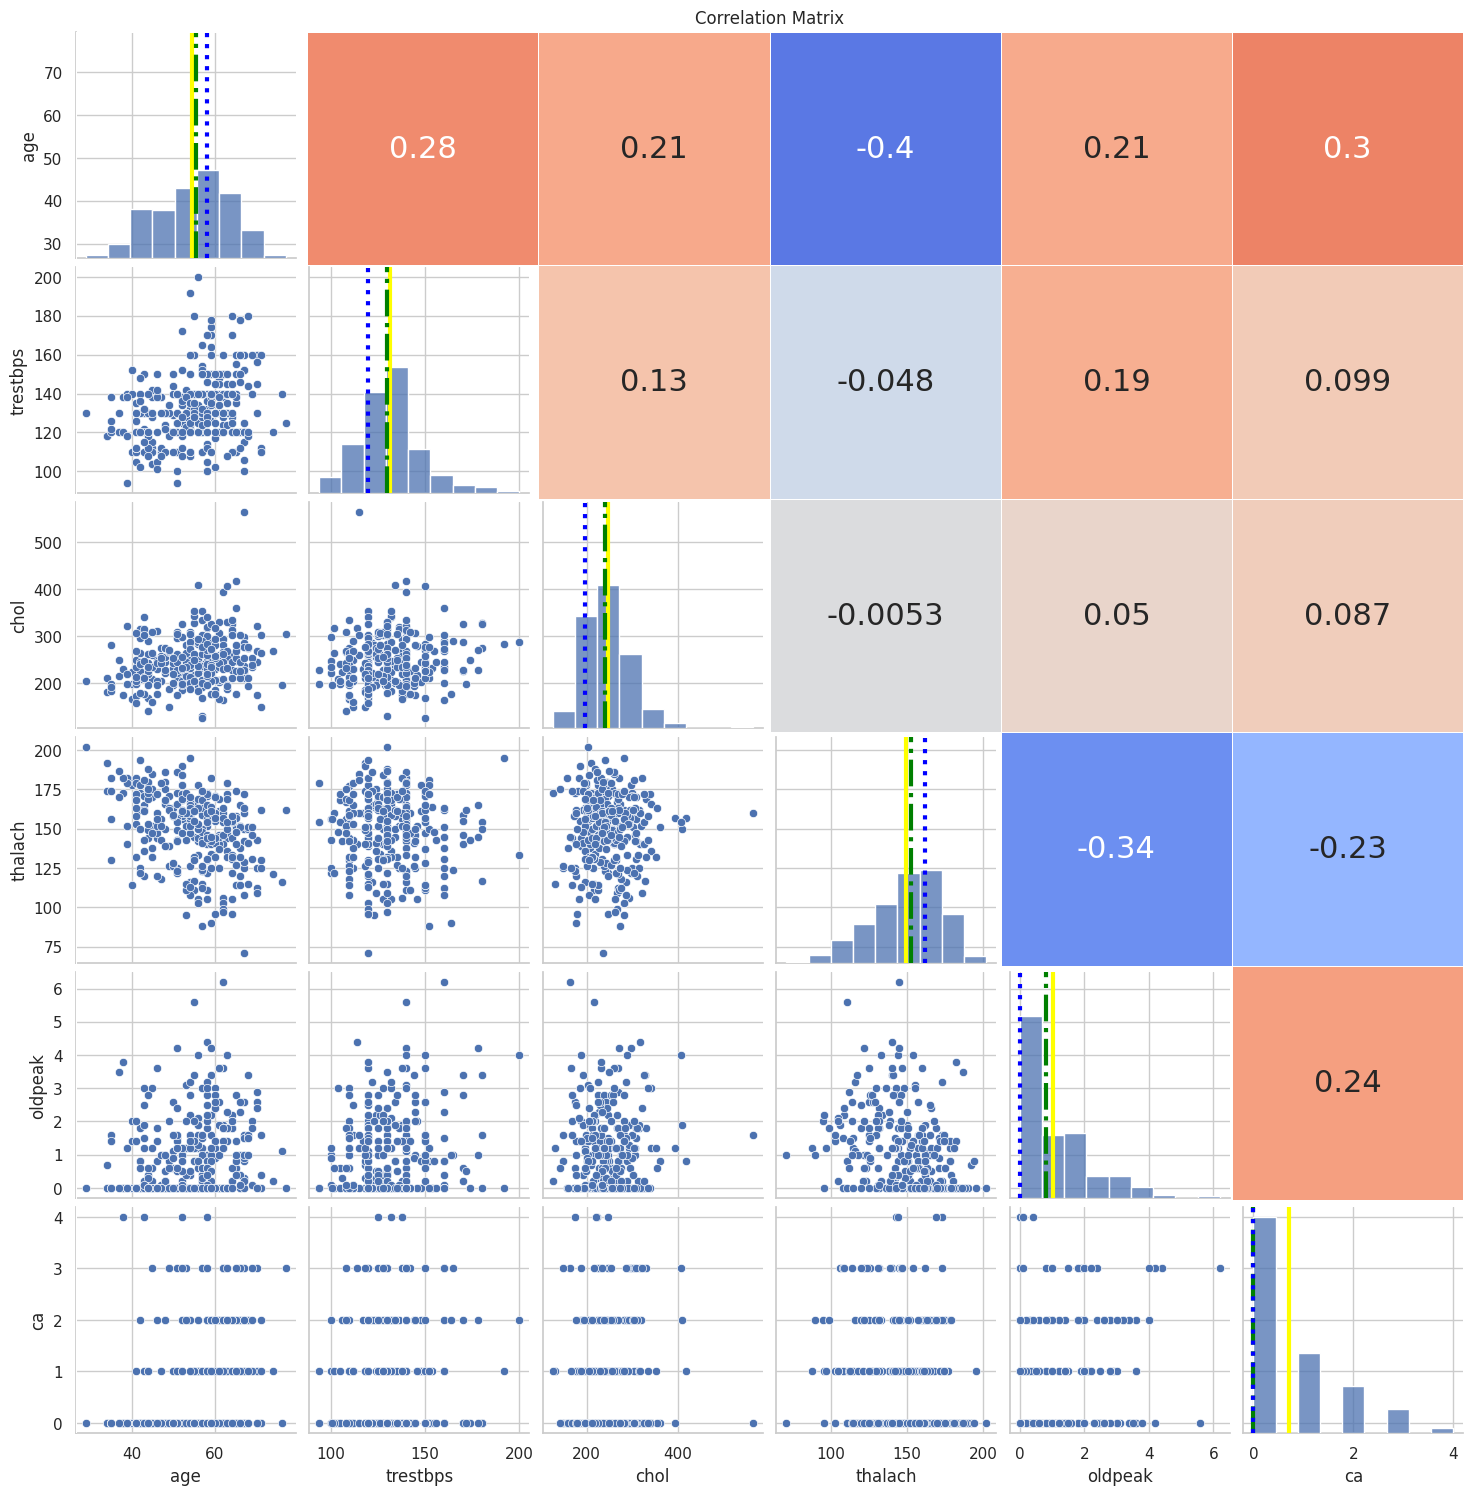

In [14]:
print("\n--- Phase 3: Bivariate & Multivariate Analysis ---")

# Source - https://stackoverflow.com/a
# Posted by JohanC, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-11, License - CC BY-SA 4.0
# https://stackoverflow.com/questions/75289515/show-median-and-quantiles-on-seaborn-pairplot-python

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

def update_diag_func(data, label, color):
    plt.axvline(np.mean(data), color='yellow', linewidth=3.0)
    plt.axvline(np.median(data), color='green', linewidth=3.0, linestyle = '-.')
    plt.axvline(stats.mode(data).mode, color='blue', linewidth=3.0 , linestyle = ':')
    

def pairplot_heatmap(d1):
    e = sns.pairplot(d1, diag_kws = {'bins':9})

    e.map_diag(update_diag_func)
    e.map_upper(hide_current_axis)

    (xmin, _), (_, ymax) = e.axes[0, 0].get_position().get_points()
    (_, ymin), (xmax, _) = e.axes[-1, -1].get_position().get_points()

    ax = e.figure.add_axes([xmin, ymin, xmax - xmin, ymax - ymin], facecolor='none')

    corr1 = d1.corr()
    mask1 = np.tril(np.ones_like(corr1, dtype=bool))
    sns.heatmap(corr1, mask=mask1, cmap='coolwarm', vmax=.5, vmin=-.5,
                linewidths=.5, cbar=False, annot=True, annot_kws={'size': 22}, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.xaxis.tick_top()
    # ax.yaxis.tick_right()

    plt.title('Correlation Matrix')
    plt.show()

pairplot_heatmap(df[numerical_var])

No sign of multicollinearity! The distribution of `oldpeak` and `ca` are highly skewed (A transformation is needed).


Generating Pair Plot (can take a moment)...


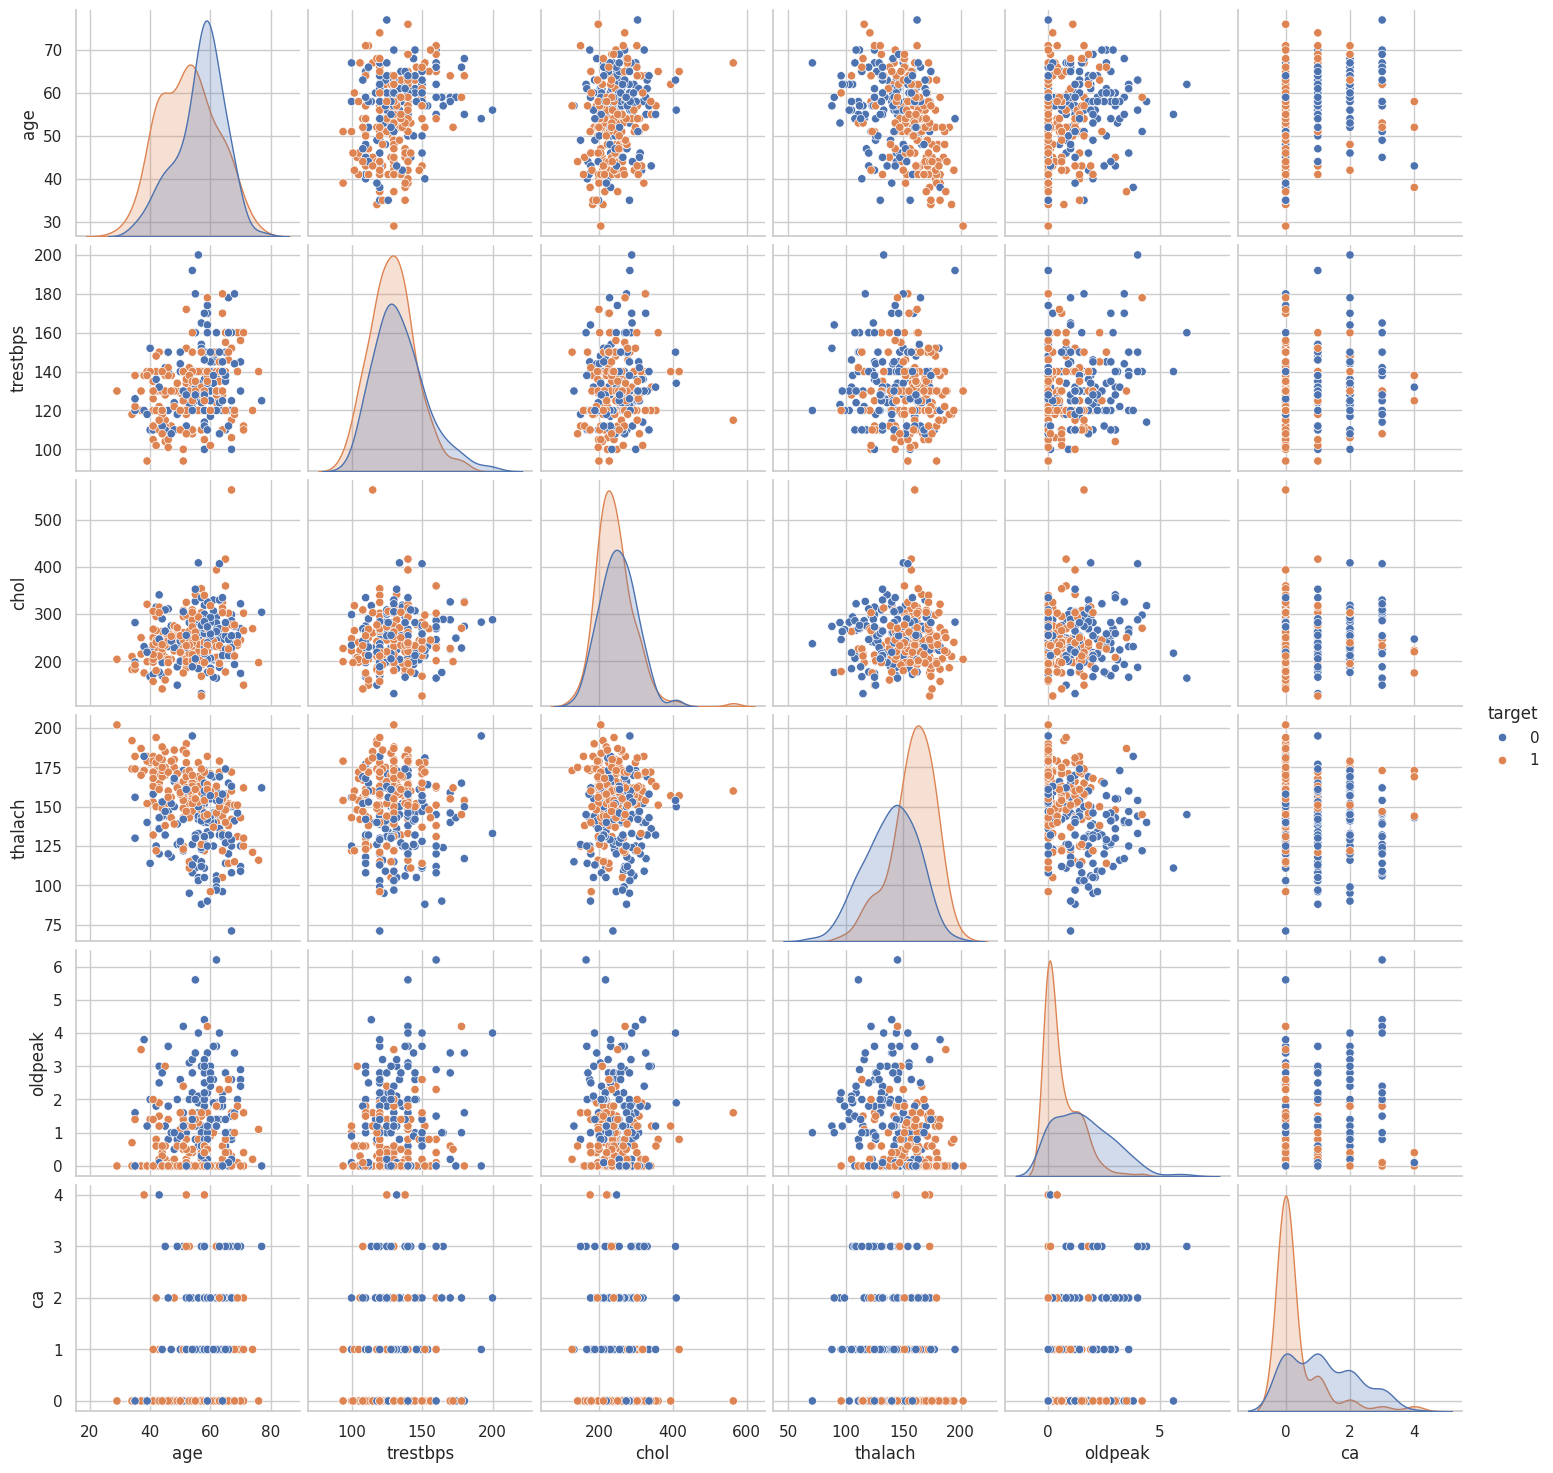

In [15]:
print("\nGenerating Pair Plot (can take a moment)...")
sns.pairplot(df[numerical_var + ['target']], hue='target', diag_kind='kde')
plt.show()


There's no sign of visible clusters.

Phase 5: Documentation

EDA complete. Review the plots and statistics.

Example Insights Found:

1. The distribution of `oldpeak` and `ca` are highly skewed (A transformation on features is needed).
2. Some numerical features like `chol`, ... have outliers.
3. No sign of multicollinearity.
4. The features are not balanced, oversampling is recommended!

# Preprocessing

In [16]:
print("Missing values per column:")
print(df.isnull().sum())

duplicate_count = df.duplicated().sum()
print(f"\nFound {duplicate_count} duplicate rows.")
#if duplicate_count > 0:
#    df = df.drop_duplicates()
#    print("Dropped duplicate rows.")

Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Found 0 duplicate rows.


In [17]:
print("--- Phase 1: Setup and Data Splitting ---")

y = df['target']

X = df.drop('target', axis=1)

# --- Train-Test Split ---
# This is the MOST IMPORTANT step to do FIRST.
# We hold back 20% of the data for testing.
# We use 'stratify=y' to ensure the test set has the same
# proportion of survivors as the training set.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.5,     
    random_state=52,
    stratify=y
)

print(f"Training set shape (X): {X_train.shape}")
print(f"Testing set shape (X): {X_test.shape}")

--- Phase 1: Setup and Data Splitting ---
Training set shape (X): (151, 13)
Testing set shape (X): (151, 13)


In [18]:
print("--- Phase 2: Building the Preprocessing Pipelines ---")

# We will build separate pipelines for each type of data.
# This makes the code clean and prevents errors.

# We first identify which columns belong to which group
# (This is a manual step based on our EDA)

# --- Sub-Pipeline 1: Numerical Features ---
# We will:
# 1. Impute missing values with the median (robust to outliers)
# 2. Scale the features using RobustScaler (robust to outliers)
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# --- Sub-Pipeline 2: Skewed Numerical Features ---
# 1. Impute with median
# 2. Use PowerTransformer (Yeo-Johnson) to make it more "normal" (Gaussian-like)
# 3. Scale the result using RobustScaler
skewed_num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('scaler', RobustScaler())
])

# --- Sub-Pipeline 3: Nominal (Unordered) Categorical Features ---
# We will:
# 1. Impute missing values with the most_frequent value (mode)
# 2. One-Hot Encode the categories into new binary columns
nominal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    # 'handle_unknown='ignore'' prevents errors if a rare category
    # appears in the test set but not the train set.
    # I don't know what a sparse output is so I remove it!
])

# --- Sub-Pipeline 4: Ordinal (Ordered) Categorical Features ---
# We will:
# 1. Impute missing values (if any) with the mode.
# 2. Encode the categories as numbers
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

--- Phase 2: Building the Preprocessing Pipelines ---


Formula of yeo johnson transformation:

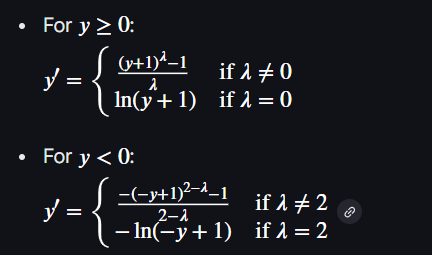

In [19]:
print("--- Phase 3: Combining Pipelines with ColumnTransformer ---")

# Now we create the master preprocessor
# This object will apply the right pipeline to the right columns
preprocessor1 = ColumnTransformer(
    transformers=[
        # (name, pipeline_object, column_list)
        ('numeric', numerical_pipeline, ['age', 'trestbps', 'chol']),
        ('skewed_numeric', skewed_num_pipeline, ['thalach', 'oldpeak', 'ca']),
        ('ordinal', ordinal_pipeline, ordinal_var),
        ('nominal', nominal_pipeline, nominal_var)
    ],
    remainder='drop',  # 'drop' any columns not listed, 'passthrough' would keep them
    verbose_feature_names_out=False
)

--- Phase 3: Combining Pipelines with ColumnTransformer ---


In [20]:
print("--- Phase 4: Fitting and Transforming the Data ---")

# --- Fit on Training Data ---
# We call .fit_transform() on the *training data only*
# This "learns" the medians, modes, scaling parameters, and categories
# from X_train and then transforms X_train.
print("Fitting preprocessor on X_train...")
X_train_preprocessed = preprocessor1.fit_transform(X_train)

# --- Transform Test Data ---
# We call .transform() on the *test data*
# This applies the parameters *learned from the training set*
# to the test set. This prevents any data leakage.
print("Transforming X_test...")
X_test_preprocessed = preprocessor1.transform(X_test)
print("...Done.\n")

print(f"Original X_train shape: {X_train.shape}")
print(f"Preprocessed X_train shape: {X_train_preprocessed.shape}")
print(f"Preprocessed X_test shape: {X_test_preprocessed.shape}")

--- Phase 4: Fitting and Transforming the Data ---
Fitting preprocessor on X_train...
Transforming X_test...
...Done.

Original X_train shape: (151, 13)
Preprocessed X_train shape: (151, 23)
Preprocessed X_test shape: (151, 23)


In [21]:
print("\n--- Phase 5: Inspecting the Preprocessed Output ---")

# The output is a NumPy array, which is what models want.
# But the column names are gone! Let's get them back.
# We can use the .get_feature_names_out() method

feature_names = preprocessor1.get_feature_names_out()
print(f"Total {len(feature_names)} features after preprocessing:")
print(list(feature_names))

# Let's put the preprocessed data back into a DataFrame to see it
df_train_preprocessed = pd.DataFrame(
    X_train_preprocessed, 
    columns=feature_names, 
    index=X_train.index
)


--- Phase 5: Inspecting the Preprocessed Output ---
Total 23 features after preprocessing:
['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'slope', 'sex_0', 'sex_1', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'fbs_0', 'fbs_1', 'restecg_0', 'restecg_1', 'exang_0', 'exang_1', 'thal_0', 'thal_1', 'thal_2', 'thal_3']


In [22]:
df_train_preprocessed.head()

,age,trestbps,chol,thalach,oldpeak,ca,slope,sex_0,sex_1,cp_0,...,fbs_0,fbs_1,restecg_0,restecg_1,exang_0,exang_1,thal_0,thal_1,thal_2,thal_3
151,-0.1250,3.1,0.796610,1.630314,-0.549916,1.000000,2.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
77,0.4375,0.5,-0.830508,-0.312551,0.910146,1.247282,2.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
78,-0.2500,0.2,-0.593220,0.179375,0.119168,1.000000,2.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
299,-0.2500,-0.5,1.508475,0.703053,-0.321523,0.000000,2.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
319,-0.1875,-0.1,-0.338983,-1.226678,-0.549916,0.000000,2.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [23]:
df_train_preprocessed[numerical_var].describe().round(2)

,age,trestbps,chol,thalach,oldpeak,ca
count,151.00,151.00,151.00,151.00,151.00,151.00
mean,-0.10,0.02,0.13,-0.05,0.03,0.46
std,0.61,0.87,0.88,0.75,0.49,0.59
min,-1.69,-1.80,-1.78,-1.72,-0.55,0.00
25%,-0.62,-0.50,-0.43,-0.56,-0.55,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.38,0.50,0.57,0.44,0.45,1.00
max,1.31,3.10,5.56,1.93,0.91,1.40


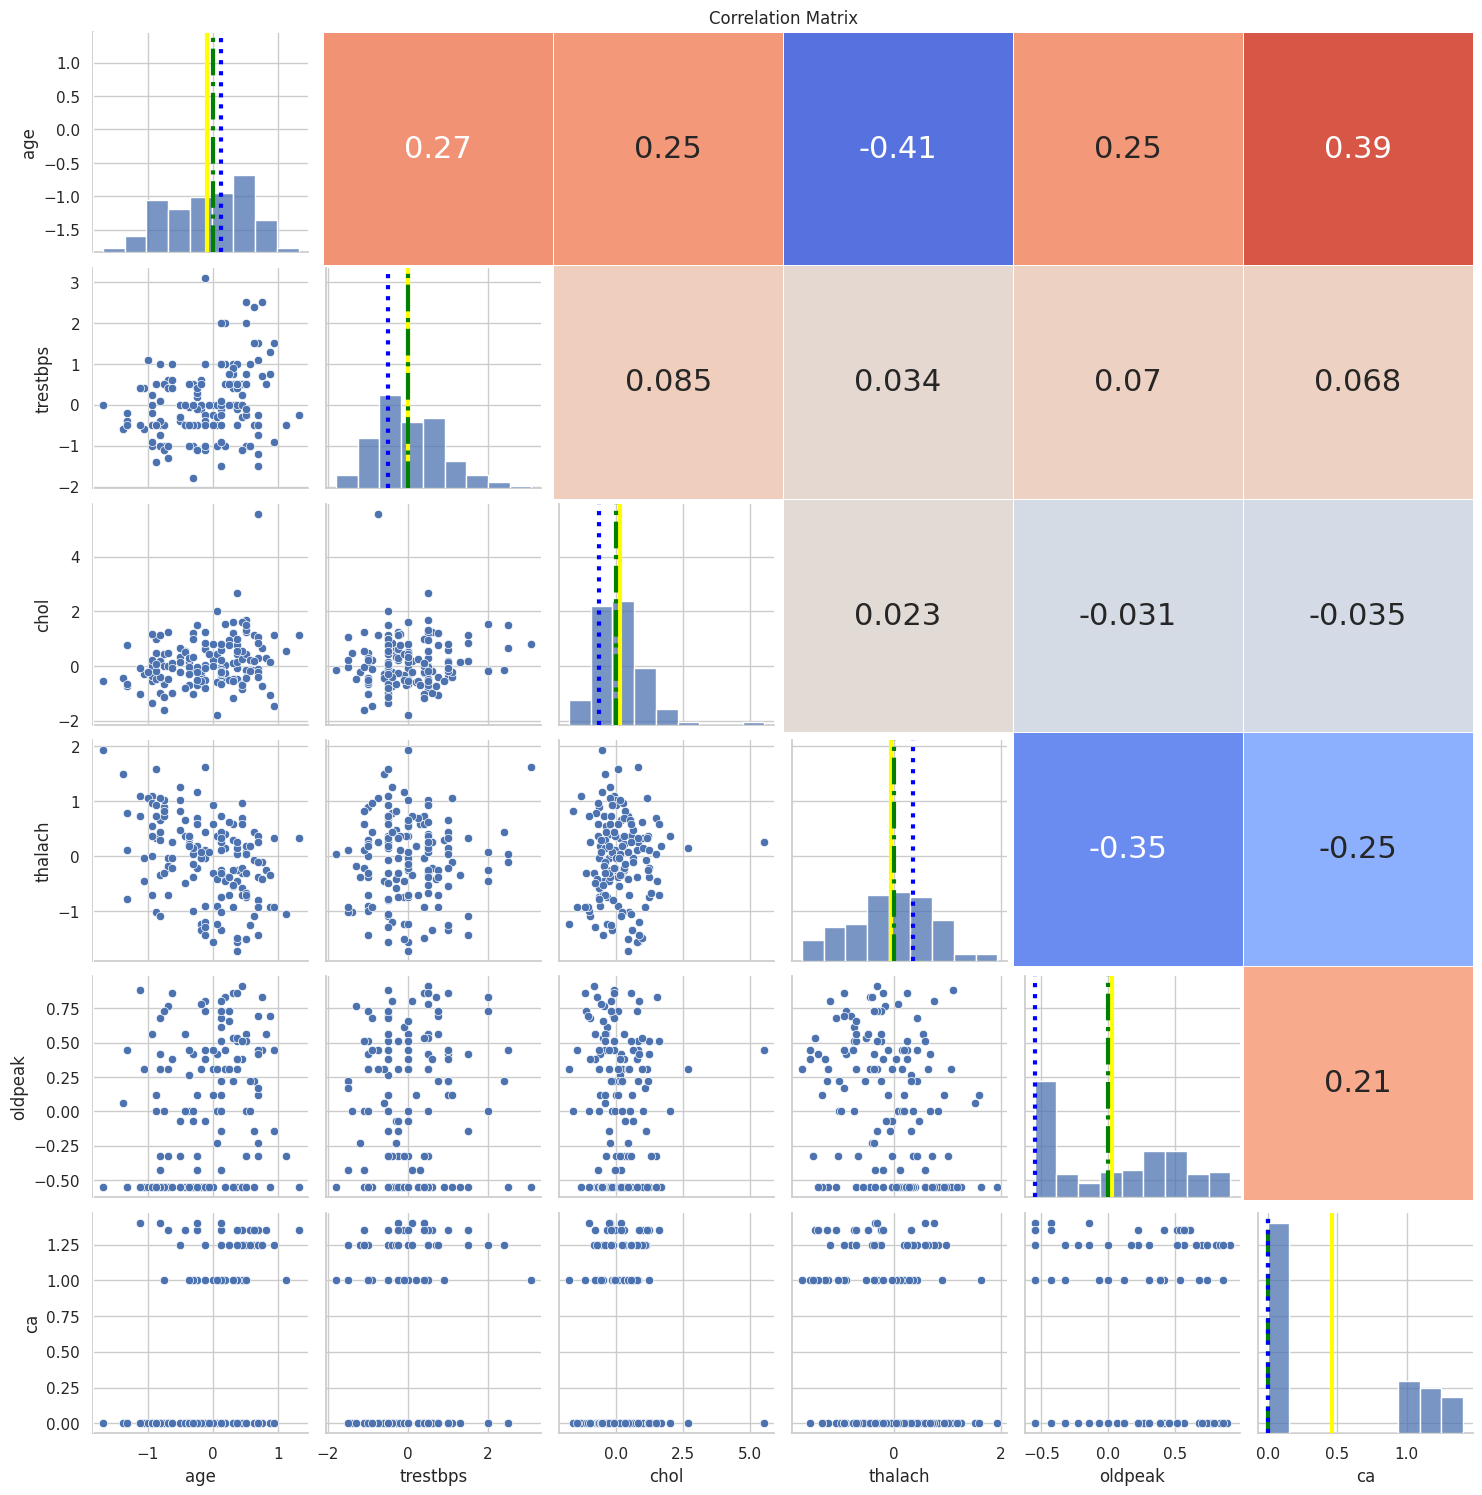

In [24]:
pairplot_heatmap(df_train_preprocessed[numerical_var])

`oldpeak` is a little symmetric now.

Let's create more preprocessors.

In [25]:
preprocessor_qtrans = ColumnTransformer(
    transformers=[
        ('numeric', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('transformer', QuantileTransformer(output_distribution= "normal")),
            ('scaler', RobustScaler())])  , numerical_var),
        ('ordinal', ordinal_pipeline, ordinal_var),
        ('nominal', nominal_pipeline, nominal_var)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

In [26]:
preprocessor_mean = ColumnTransformer(
    transformers=[
        ('numeric', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')), # this preprocessor will probably underperform
            ('transformer', PowerTransformer(method='yeo-johnson')),
            ('scaler', RobustScaler())])  , numerical_var),
        ('ordinal', ordinal_pipeline, ordinal_var),
        ('nominal', nominal_pipeline, nominal_var)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

In [27]:
# No transformation
preprocessor_notrans = ColumnTransformer(
    transformers=[
        ('numeric', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler())])  , numerical_var),
        ('ordinal', ordinal_pipeline, ordinal_var),
        ('nominal', nominal_pipeline, nominal_var)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

Note: we will add oversampling methods in the next section.

# Modeling

In [28]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [29]:
print("--- Practical Step : Build, Train & Predict ---")

# We will create three separate, complete pipelines.
# Each pipeline combines the *preprocessor* with one *model*.
# This is the best practice.

pipelines = {
    "KNN": Pipeline(steps=[('preprocessor', preprocessor1), ('model', KNeighborsClassifier())]),
    "LogisticRegression": Pipeline(steps=[('preprocessor', preprocessor1), ('model', LogisticRegression(random_state=42, max_iter=1000))]),
    "DecisionTree": Pipeline(steps=[('preprocessor', preprocessor1), ('model', DecisionTreeClassifier(random_state=42))]),
    "LogisticRegression_SMOTE": ImbPipeline(steps=[('preprocessor', preprocessor1), ('sampler', SMOTE()), ('model', LogisticRegression(random_state=42, max_iter=1000))]),
    "LDA": Pipeline(steps=[('preprocessor', preprocessor1), ('model', LDA())]),
    "QDA": ImbPipeline(steps=[('preprocessor', preprocessor1), ('sampler', SMOTE()), ('model', QDA(reg_param = 0.1))]),
}


# Model 4: Random Forest
# Intuition: An "ensemble" model. It builds hundreds of
# different Decision Trees on random subsets of the data
# and features. To make a prediction, it takes a "majority vote"
# from all the trees. This fixes the overfitting problem of single trees.
pipelines['RandomForest'] = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
    # n_estimators=100 means build 100 trees
])

# Model 5: Support Vector Machine (SVM)
# Intuition: A "maximum margin" classifier. It tries to find the
# single best line (or hyperplane in high dimensions) that
# separates the classes with the *widest possible margin* or "street".
pipelines['SVM'] = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('model', SVC(random_state=42, probability=True))
    # *** CRITICAL ***: We *must* set probability=True
    # so we can get the scores needed for the ROC curve.
    # This can make it train slower.
])

# Model 6: Naive Bayes (Gaussian)
# Intuition: A fast, simple model based on probability (Bayes' Theorem).
# It's "naive" because it assumes all features are independent
# of each other (e.g., 'age' has no effect on 'fare').
# We use 'GaussianNB' which assumes our continuous features
# (after scaling) are normally distributed (Gaussian).
pipelines['GaussianNB'] = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('model', GaussianNB())
])

# Train KNN
print("Training KNN...")
pipelines['KNN'].fit(X_train, y_train)
print("...KNN training complete.")

# Train Logistic Regression
print("Training Logistic Regression...")
pipelines['LogisticRegression'].fit(X_train, y_train)
print("...Logistic Regression training complete.")

# Train Decision Tree
print("Training Decision Tree...")
pipelines['DecisionTree'].fit(X_train, y_train)
print("...Decision Tree training complete.\n")

# --- Make Predictions on the Test Set ---
print("--- Making predictions on X_test ---")

# Predict with KNN
y_pred_knn = pipelines['KNN'].predict(X_test)

# Predict with Logistic Regression
y_pred_log_reg = pipelines['LogisticRegression'].predict(X_test)

# Predict with Decision Tree
y_pred_tree = pipelines['DecisionTree'].predict(X_test)

# --- Show Example Predictions ---
print("--- Example Predictions ---")
# Let's create a DataFrame to easily compare them
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'KNN_Prediction': y_pred_knn,
    'LogReg_Prediction': y_pred_log_reg,
    'Tree_Prediction': y_pred_tree
})

print("Comparison of actual values vs. model predictions (first 20 rows):")
print(predictions_df.head(20))

predictions = {}
predictions_proba = {} # For ROC curve

print("--- Training and Predicting ---")
for name, pipe in pipelines.items():
    print(f"Training {name}...")
    pipe.fit(X_train, y_train)
    # Get hard predictions (0 or 1)
    predictions[name] = pipe.predict(X_test)
    # Get probability predictions (for ROC)
    # We only want the probability of the positive class (1)
    if hasattr(pipe, "predict_proba"):
        predictions_proba[name] = pipe.predict_proba(X_test)[:, 1]
    else:
        # KNN doesn't have predict_proba by default in the same way, but we can get it
        predictions_proba[name] = pipe.predict_proba(X_test)[:, 1]


--- Practical Step : Build, Train & Predict ---
Training KNN...
...KNN training complete.
Training Logistic Regression...
...Logistic Regression training complete.
Training Decision Tree...
...Decision Tree training complete.

--- Making predictions on X_test ---
--- Example Predictions ---
Comparison of actual values vs. model predictions (first 20 rows):
    Actual  KNN_Prediction  LogReg_Prediction  Tree_Prediction
723      1               1                  1                1
166      0               0                  0                0
426      1               1                  1                1
218      0               0                  0                0
570      1               1                  1                1
708      1               1                  1                1
129      1               0                  0                1
17       0               0                  0                0
36       1               0                  1                1
244      1 

In [30]:
predictions_proba['KNN'][0:5]

array([1. , 0. , 1. , 0.2, 0.8])

# Evaluation

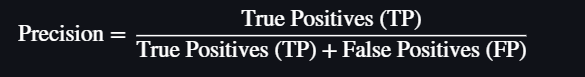

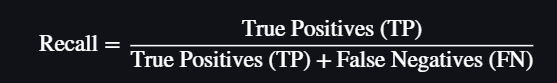

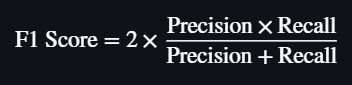

![](pic/conf-mat.png)

Let's say:

Negative : disease 

Positive : no disease

In this case large False Positive would be a disaster! So we should try to minimize FP as mush as possible!

In [31]:
# Let's calculate this for Logistic Regression 
((predictions['LogisticRegression']==1) * (y_test.astype('int64')==1)).sum()/((y_test.astype('int64')==1)).sum()

np.float64(0.8536585365853658)

--- Model Evaluation ---

--- Results for KNN ---
Classification Report:
              precision    recall  f1-score   support

  no disease      0.783     0.783     0.783        69
     disease      0.817     0.817     0.817        82

    accuracy                          0.801       151
   macro avg      0.800     0.800     0.800       151
weighted avg      0.801     0.801     0.801       151

Confusion Matrix:


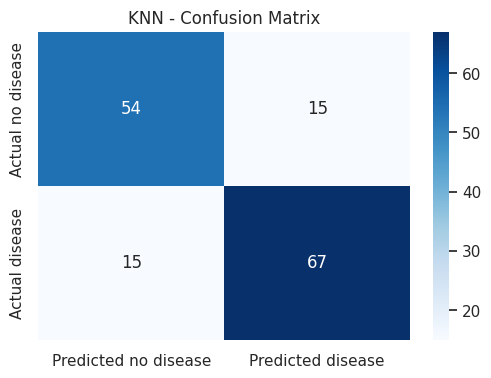


--- Results for LogisticRegression ---
Classification Report:
              precision    recall  f1-score   support

  no disease      0.815     0.768     0.791        69
     disease      0.814     0.854     0.833        82

    accuracy                          0.815       151
   macro avg      0.815     0.811     0.812       151
weighted avg      0.815     0.815     0.814       151

Confusion Matrix:


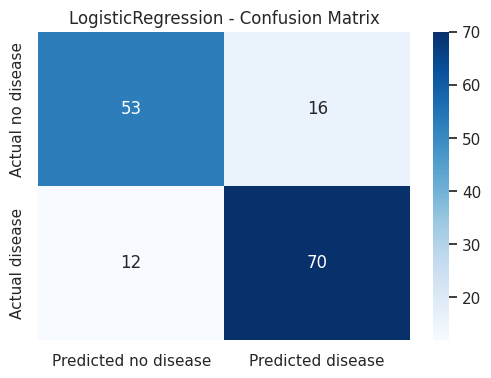


--- Results for DecisionTree ---
Classification Report:
              precision    recall  f1-score   support

  no disease      0.761     0.783     0.771        69
     disease      0.812     0.793     0.802        82

    accuracy                          0.788       151
   macro avg      0.787     0.788     0.787       151
weighted avg      0.789     0.788     0.788       151

Confusion Matrix:


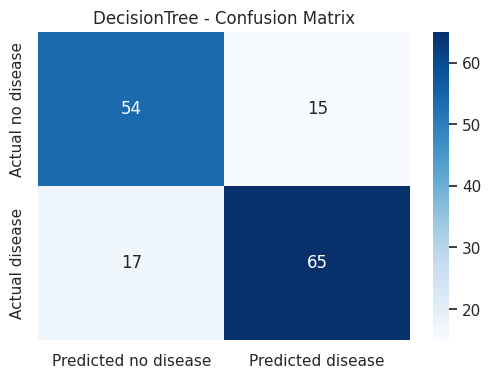


--- Results for LogisticRegression_SMOTE ---
Classification Report:
              precision    recall  f1-score   support

  no disease      0.815     0.768     0.791        69
     disease      0.814     0.854     0.833        82

    accuracy                          0.815       151
   macro avg      0.815     0.811     0.812       151
weighted avg      0.815     0.815     0.814       151

Confusion Matrix:


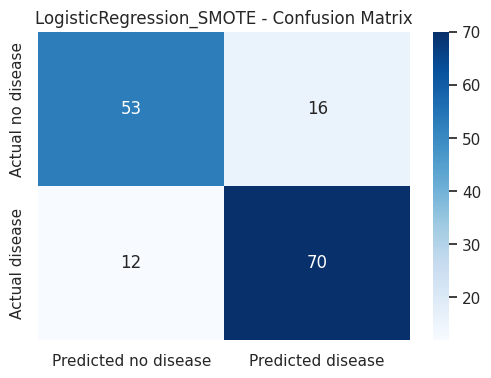


--- Results for LDA ---
Classification Report:
              precision    recall  f1-score   support

  no disease      0.815     0.768     0.791        69
     disease      0.814     0.854     0.833        82

    accuracy                          0.815       151
   macro avg      0.815     0.811     0.812       151
weighted avg      0.815     0.815     0.814       151

Confusion Matrix:


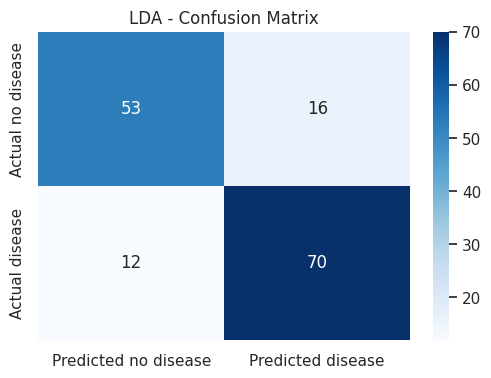


--- Results for QDA ---
Classification Report:
              precision    recall  f1-score   support

  no disease      0.781     0.826     0.803        69
     disease      0.846     0.805     0.825        82

    accuracy                          0.815       151
   macro avg      0.813     0.815     0.814       151
weighted avg      0.816     0.815     0.815       151

Confusion Matrix:


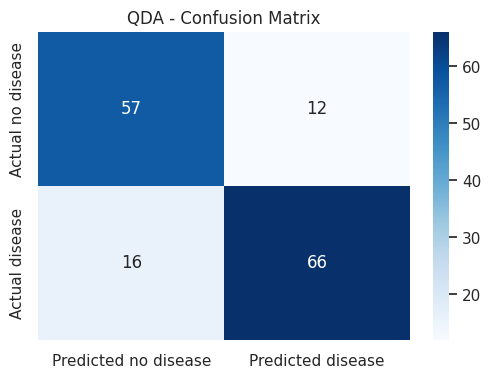


--- Results for RandomForest ---
Classification Report:
              precision    recall  f1-score   support

  no disease      0.797     0.797     0.797        69
     disease      0.829     0.829     0.829        82

    accuracy                          0.815       151
   macro avg      0.813     0.813     0.813       151
weighted avg      0.815     0.815     0.815       151

Confusion Matrix:


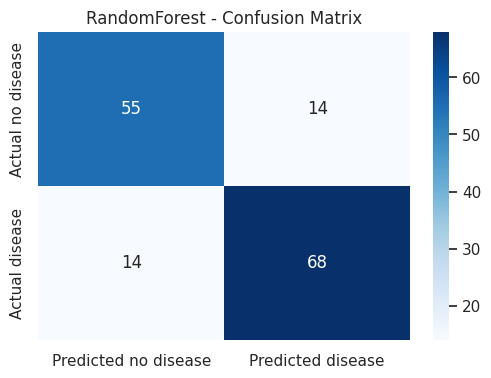


--- Results for SVM ---
Classification Report:
              precision    recall  f1-score   support

  no disease      0.771     0.783     0.777        69
     disease      0.815     0.805     0.810        82

    accuracy                          0.795       151
   macro avg      0.793     0.794     0.793       151
weighted avg      0.795     0.795     0.795       151

Confusion Matrix:


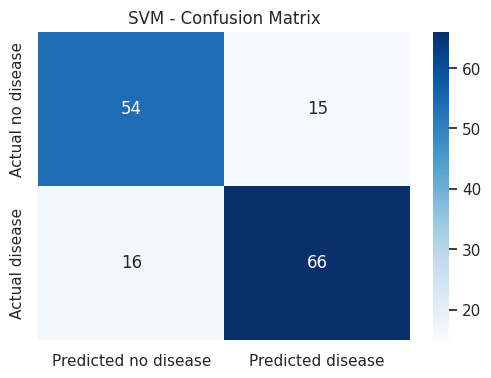


--- Results for GaussianNB ---
Classification Report:
              precision    recall  f1-score   support

  no disease      0.593     0.928     0.723        69
     disease      0.884     0.463     0.608        82

    accuracy                          0.675       151
   macro avg      0.738     0.695     0.666       151
weighted avg      0.751     0.675     0.661       151

Confusion Matrix:


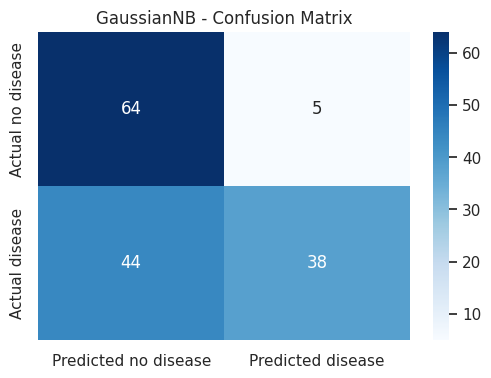


--- ROC Curve Comparison ---


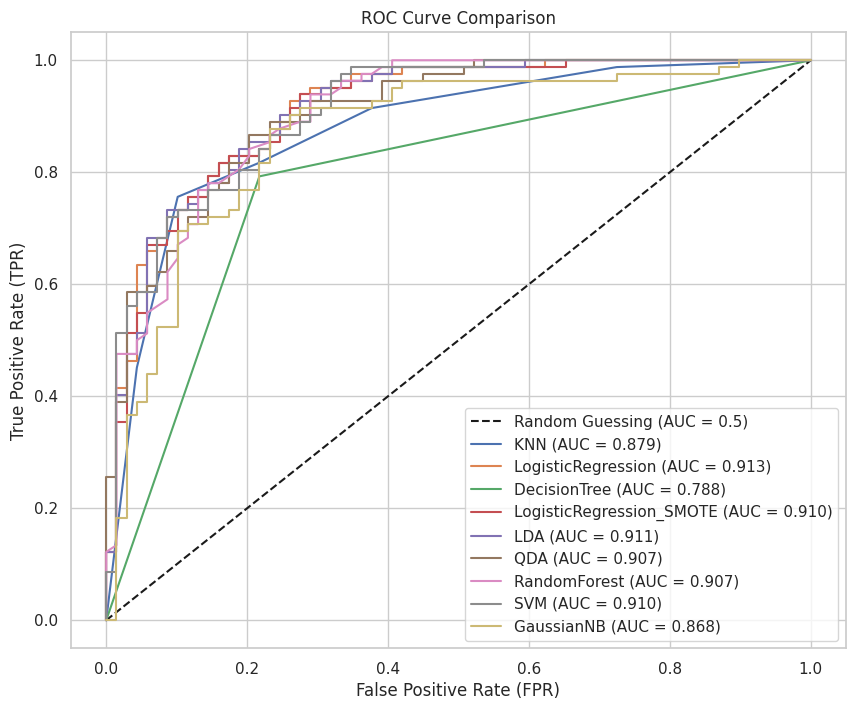


--- 10-Fold Cross-Validation (Robustness Check) ---
Model: KNN
  All 10 scores: [0.742 0.903 0.833 0.833 0.833 0.933 0.733 0.733 0.8   0.767]
  Mean Accuracy: 0.811
  Std Deviation: 0.066
--------------------
Model: LogisticRegression
  All 10 scores: [0.871 0.903 0.867 0.8   0.833 1.    0.8   0.767 0.767 0.833]
  Mean Accuracy: 0.844
  Std Deviation: 0.067
--------------------
Model: DecisionTree
  All 10 scores: [0.903 0.677 0.767 0.7   0.767 0.8   0.667 0.667 0.733 0.767]
  Mean Accuracy: 0.745
  Std Deviation: 0.070
--------------------
Model: LogisticRegression_SMOTE
  All 10 scores: [0.871 0.903 0.867 0.8   0.833 1.    0.767 0.733 0.733 0.833]
  Mean Accuracy: 0.834
  Std Deviation: 0.078
--------------------
Model: LDA
  All 10 scores: [0.839 0.903 0.867 0.8   0.9   1.    0.733 0.733 0.767 0.767]
  Mean Accuracy: 0.831
  Std Deviation: 0.083
--------------------
Model: QDA
  All 10 scores: [0.871 0.839 0.767 0.8   0.8   0.967 0.733 0.733 0.767 0.8  ]
  Mean Accuracy: 0.808
  St

In [32]:
print("--- Model Evaluation ---")

for name, y_pred in predictions.items():
    print(f"\n--- Results for {name} ---")
    
    # This gives you Precision, Recall, and F1-Score all at once!
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["no disease", "disease"] , digits = 3))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["Predicted no disease", "Predicted disease"], 
                yticklabels=["Actual no disease", "Actual disease"])
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

print("\n--- ROC Curve Comparison ---")
plt.figure(figsize=(10, 8))

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')

for name, probas in predictions_proba.items():
    fpr, tpr, thresholds = roc_curve(y_test, probas)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


print("\n--- 10-Fold Cross-Validation (Robustness Check) ---")
# This runs the *entire* fit/predict process 10 times
# We use the full X and y, not the train/test split

for name, pipe in pipelines.items():
    # 'cv=10' means 10-fold
    # 'scoring='accuracy'' is what we'll measure
    scores = cross_val_score(pipe, X, y, cv=10, scoring='accuracy')
    
    print(f"Model: {name}")
    print(f"  All 10 scores: {np.round(scores, 3)}")
    print(f"  Mean Accuracy: {scores.mean():.3f}")
    print(f"  Std Deviation: {scores.std():.3f}")
    print("-" * 20)

Since it's more important to detect sick people correctly, which has a higher recall for disease

So, it looks like Logistic Regression is the best model, since it has the highest recall for disease and AUC!

### Let's see the results of SMOTE

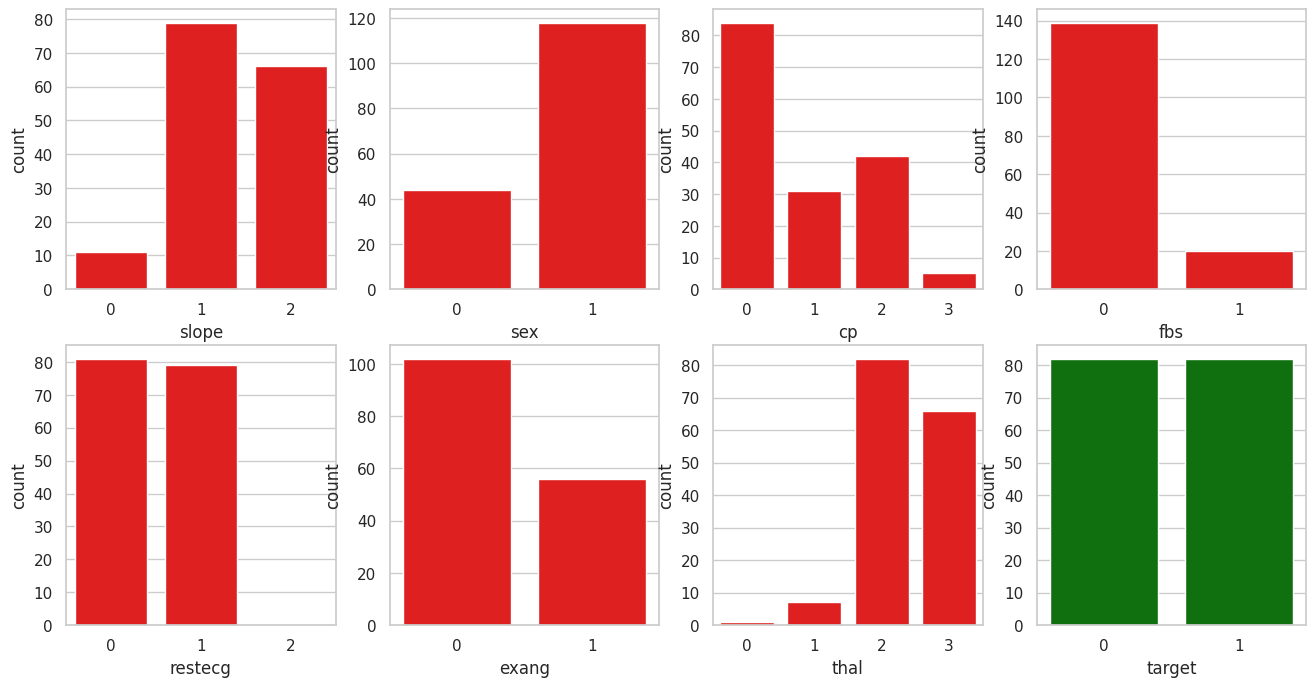

In [43]:
X_train_res, y_train_res = pipelines['LogisticRegression_SMOTE']['sampler'].fit_resample(X_train, y_train)
df_train_res = pd.concat([X_train_res,y_train_res], axis = 1)
cats = np.reshape(ordinal_var+nominal_var+['target'],(2,4))
alpha = 4
fig, axs = plt.subplots(ncols = 4, nrows = 2, figsize=(4*alpha, 2*alpha))
for i in range(cats.shape[0]):
    for j in range(cats.shape[1]):
        cl = 'green'
        pval = stats.chisquare(df_train_res[cats[i][j]].value_counts().values).pvalue
        if pval < 0.05:
            cl = 'red'
        sns.countplot(x=df_train_res[cats[i][j]], ax = axs[i][j], color = cl)


So, it looks like it does not balance features... anyways, WHO CARES REALLY!

# Final model

Let's take it to the extreme!